In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import torch
# import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data

from livelossplot import PlotLosses

In [ ]:
torch.cuda.is_available()

## Linear regression

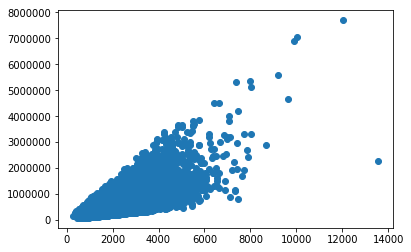

In [2]:
df_data = pd.read_csv("kc_house_data.csv")

x_data = df_data['sqft_living'].values.reshape(-1, 1).astype(np.float32)
y_data = df_data["price"].values.reshape(-1, 1).astype(np.float32)

plt.scatter(x_data, y_data);

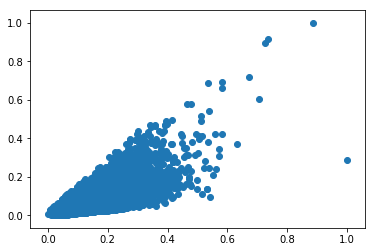

In [3]:
# minmax scaler
minmax_scaler = MinMaxScaler()

x_data = minmax_scaler.fit_transform(x_data)
y_data = minmax_scaler.fit_transform(y_data)

plt.scatter(x_data, y_data);

In [ ]:
# standard scaler
std_scaler = StandardScaler()

x_data = std_scaler.fit_transform(x_data)
y_data = std_scaler.fit_transform(y_data)

plt.scatter(x_data, y_data);

In [ ]:
# robust scaler
robust_scaler = RobustScaler()

x_data = robust_scaler.fit_transform(x_data)
y_data = robust_scaler.fit_transform(y_data)

plt.scatter(x_data, y_data);

### Data Preparation

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [5]:
params = {
    'batch_size': 32,
    'num_workers': 8
}

# Generators
training_set = data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
training_generator = data.DataLoader(training_set, shuffle=True, **params)

validation_set = data.TensorDataset(torch.from_numpy(x_validation), torch.from_numpy(y_validation))
validation_generator = data.DataLoader(validation_set, shuffle=False, **params)

test_set = data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_generator = data.DataLoader(test_set, shuffle=False, **params)

### Model

In [6]:
class LinearRegression(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(LinearRegression, self).__init__()
        self.i2o = nn.Linear(x_dim, y_dim, bias=True)
        self.loss = nn.MSELoss()
        
        
    def forward(self, x):
        return self.i2o(x)
    
    
    def train_(self, generator, epochs, lr=0.01, step=2, device="cpu"):
        self = self.to(device)
        self.optim = torch.optim.SGD(self.parameters(), lr=lr)
        liveloss = PlotLosses()

        for epoch in range(epochs):
            if epoch % step == 0:
                logs = {}
                for phase in ["train", "eval"]:
                    self.train() if phase == 'train' else self.eval()
                    running_loss = 0.0
                    
                    for x_data, y_data in generator[phase]:
                        x_data, y_data = x_data.to(device), y_data.to(device)
                        y_pred = self.forward(x_data)
                        loss = self.loss(y_pred, y_data)

                        if phase == "train":
                            self.optim.zero_grad()
                            loss.backward()
                            self.optim.step()
                            
                        running_loss += loss.item() * x_data.shape[0]

                    size = len(generator[phase].dataset)
                    logs[phase + "loss"] = running_loss / size
                    
                liveloss.update(logs)
                liveloss.draw()

            else:
                self.train()
                for x_data, y_data in generator["train"]:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    loss = self.loss(y_pred, y_data)

                    self.optim.zero_grad()
                    loss.backward()
                    self.optim.step()
                    
                    
    def test(self, test_generator, device="cpu"):
            self.eval()
            running_loss = 0
            with torch.no_grad():
                for x_data, y_data in test_generator:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    running_loss += self.loss(y_pred, y_data).item() * x_data.shape[0]
            
            size = len(test_generator.dataset)
            print('Test MSE of the model on the {} test data: {}'.format(size, running_loss / size))
            
        

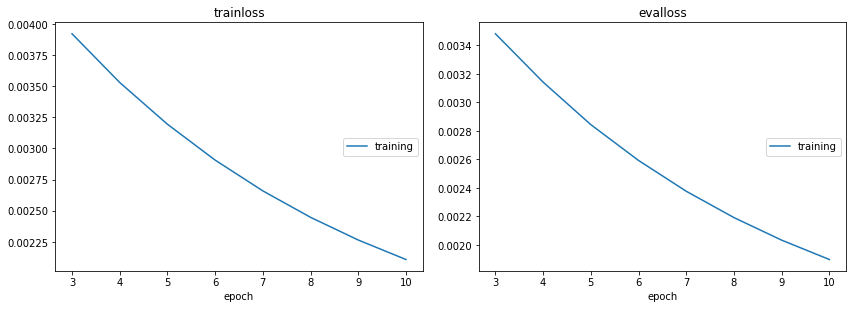

trainloss:
training   (min:    0.002, max:    0.016, cur:    0.002)

evalloss:
training   (min:    0.002, max:    0.004, cur:    0.002)


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

params_model = {
    "x_dim": 1,
    "y_dim": 1
}

params_train = {
    "generator": {
        "train": training_generator,
        "eval": validation_generator
    },
    "epochs": 20,
    "lr": 0.01,
    "step": 2,
    "device": device
}


linear_regression = LinearRegression(**params_model)

linear_regression.train_(**params_train)

Test MSE of the model on the 4323 test data: 0.0022795864490848384


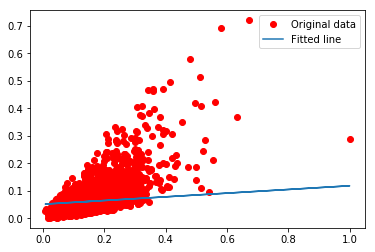

In [8]:
y_pred = linear_regression.forward(torch.from_numpy(x_test)).detach().numpy()
plt.plot(x_test, y_test, 'ro', label='Original data');
plt.plot(x_test, y_pred, label='Fitted line');
plt.legend();

linear_regression.test(test_generator, device=device)

In [9]:
linear_regression.i2o.state_dict()

OrderedDict([('weight', tensor([[0.0670]])), ('bias', tensor([0.0510]))])

# Logistic Regression

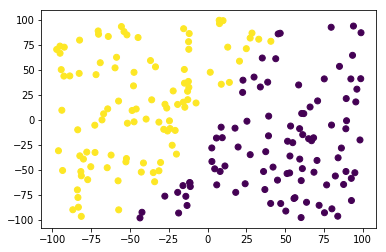

In [10]:
x_data = np.random.uniform(-100, 100, size=(200, 2)).astype(np.float32)
theta = np.random.uniform(-5, 5, size=(2,1))
y_data = (x_data[:, 1] > (x_data[:, 0] * theta[0] + theta[1])).astype(np.float32)
y_data = y_data.reshape(-1, 1)

plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data.squeeze());

### Data Preparation

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [12]:
params = {
    'batch_size': 32,
    'num_workers': 8
}

# Generators
training_set = data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
training_generator = data.DataLoader(training_set, shuffle=True, **params)

validation_set = data.TensorDataset(torch.from_numpy(x_validation), torch.from_numpy(y_validation))
validation_generator = data.DataLoader(validation_set, shuffle=False, **params)

test_set = data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_generator = data.DataLoader(test_set, shuffle=False, **params)

### Model

In [13]:
class LogisticRegression(nn.Module):
    def  __init__(self, x_dim, y_dim=1):
        super(LogisticRegression, self).__init__()
        self.i2o = nn.Linear(x_dim, y_dim, bias=True)
        self.o_activation = nn.Sigmoid()
        self.loss = nn.BCELoss()
        
        
    def forward(self, x):
        return F.sigmoid(self.i2o(x))
    
    
    def train_(self, generator, epochs, lr=0.01, step=2, device="cpu"):
        self = self.to(device)
        self.optim = torch.optim.SGD(self.parameters(), lr=lr)
        liveloss = PlotLosses()

        for epoch in range(epochs):
            if epoch % step == 0:
                logs = {}
                for phase in ["train", "eval"]:
                    self.train() if phase == 'train' else self.eval()
                    running_loss = 0.0
                    
                    for x_data, y_data in generator[phase]:
                        x_data, y_data = x_data.to(device), y_data.to(device)
                        y_pred = self.forward(x_data)
                        loss = self.loss(y_pred, y_data)

                        if phase == "train":
                            self.optim.zero_grad()
                            loss.backward()
                            self.optim.step()
                            
                        running_loss += loss.item() * x_data.shape[0]
                        
                    size = len(generator[phase].dataset)
                    logs[phase + "loss"] = running_loss / size
                    
                liveloss.update(logs)
                liveloss.draw()

            else:
                self.train()
                for x_data, y_data in generator["train"]:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    loss = self.loss(y_pred, y_data)

                    self.optim.zero_grad()
                    loss.backward()
                    self.optim.step()

                    
    def test(self, test_generator, device="cpu"):
            self.eval()
            running_loss = 0
            with torch.no_grad():
                for x_data, y_data in test_generator:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    running_loss += self.loss(y_pred, y_data).item() * x_data.shape[0]
            
            size = len(test_generator.dataset)
            print('Test MSE of the model on the {} test data: {}'.format(size, running_loss / size))
        

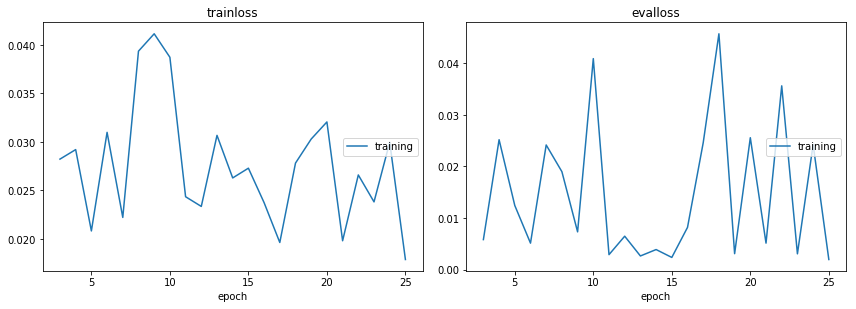

trainloss:
training   (min:    0.018, max:    0.779, cur:    0.018)

evalloss:
training   (min:    0.002, max:    0.046, cur:    0.002)


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

params_model = {
    "x_dim": 2,
    "y_dim": 1
}

params_train = {
    "generator": {
        "train": training_generator,
        "eval": validation_generator
    },
    "epochs": 50,
    "lr": 0.01,
    "step": 2,
    "device": device
}


logistic_regression = LogisticRegression(**params_model)

logistic_regression.train_(**params_train)

In [18]:
logistic_regression.test(test_generator, device=device)

Test MSE of the model on the 40 test data: 0.01282032579184147


### Evaluation

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
y_pred = logistic_regression.forward(torch.from_numpy(x_test)).detach().numpy()

# roc score
roc_auc_score(y_test, y_pred)

1.0

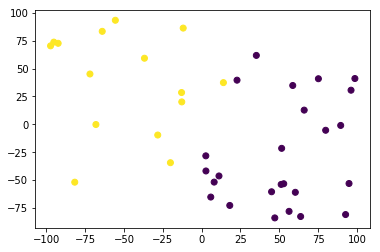

In [21]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test.squeeze());

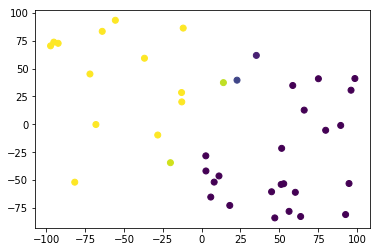

In [22]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred.squeeze());

In [23]:
logistic_regression.state_dict()

OrderedDict([('i2o.weight', tensor([[-0.4609,  0.2149]])),
             ('i2o.bias', tensor([0.6637]))])

# Feed Forward Network

In [ ]:
x_data = 10 * np.random.random(size=(10000, 1)) - 3
x_data = x_data.astype(np.float32)
y_data = 10*np.sin(x_data) + x_data

plt.scatter(x_data, y_data);

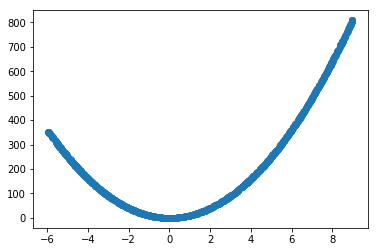

In [24]:
x_data = 15 * np.random.random(size=(1000, 1)) - 6
x_data = x_data.astype(np.float32)
y_data = 10*x_data**2

plt.scatter(x_data, y_data);

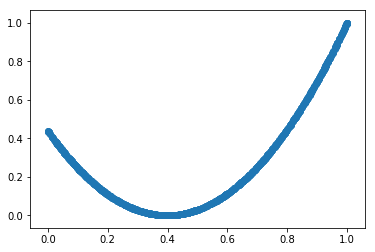

In [25]:
# minmax scaler
minmax_scaler = MinMaxScaler()

x_data = minmax_scaler.fit_transform(x_data)
y_data = minmax_scaler.fit_transform(y_data)

plt.scatter(x_data, y_data);

### Data Preparation

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [27]:
params = {
    'batch_size': 32,
    'num_workers': 8
}

# Generators
training_set = data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
training_generator = data.DataLoader(training_set, shuffle=True, **params)

validation_set = data.TensorDataset(torch.from_numpy(x_validation), torch.from_numpy(y_validation))
validation_generator = data.DataLoader(validation_set, shuffle=False, **params)

test_set = data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_generator = data.DataLoader(test_set, shuffle=False, **params)

### Model

In [29]:
class FFNN(nn.Module):
    def __init__(self, x_dim, h_dim, y_dim, dropout_prob):
        super(FFNN, self).__init__()
        self.i2h = nn.Linear(x_dim, h_dim)
        self.h2o = nn.Linear(h_dim, y_dim)
        
        self.bn1 = nn.BatchNorm1d(h_dim)
        self.drop1 = nn.Dropout(p=dropout_prob)
        self.loss = nn.MSELoss()
        
        
    def forward(self, x):
        x = self.i2h(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.h2o(x)
        return x
    
    
    def train_(self, generator, epochs, lr=0.01, step=2, device="cpu"):
        self = self.to(device)
        self.optim = torch.optim.SGD(self.parameters(), lr=lr)
        liveloss = PlotLosses()

        for epoch in range(epochs):
            if epoch % step == 0:
                logs = {}
                for phase in ["train", "eval"]:
                    self.train() if phase == 'train' else self.eval()
                    running_loss = 0.0
                    
                    for x_data, y_data in generator[phase]:
                        x_data, y_data = x_data.to(device), y_data.to(device)
                        y_pred = self.forward(x_data)
                        loss = self.loss(y_pred, y_data)

                        if phase == "train":
                            self.optim.zero_grad()
                            loss.backward()
                            self.optim.step()
                            
                        running_loss += loss.item() * x_data.shape[0]
                    
                    size = len(generator[phase].dataset)
                    logs[phase + "loss"] = running_loss / size
                    
                liveloss.update(logs)
                liveloss.draw()

            else:
                self.train()
                for x_data, y_data in generator["train"]:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    loss = self.loss(y_pred, y_data)

                    self.optim.zero_grad()
                    loss.backward()
                    self.optim.step()
                    
                    
    def test(self, test_generator, device="cpu"):
            self.eval()
            running_loss = 0
            with torch.no_grad():
                for x_data, y_data in test_generator:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    running_loss += self.loss(y_pred, y_data).item() * x_data.shape[0]
            
            size = len(test_generator.dataset)
            print('Test MSE of the model on the {} test data: {}'.format(size, running_loss / size))
            

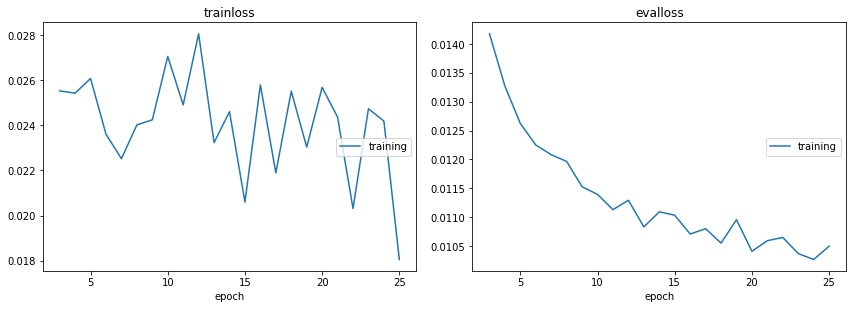

trainloss:
training   (min:    0.018, max:    0.039, cur:    0.018)

evalloss:
training   (min:    0.010, max:    0.047, cur:    0.010)


In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

params_model = {
    "x_dim": 1,
    "h_dim": 5,
    "y_dim": 1,
    "dropout_prob": 0.3
}

params_train = {
    "generator": {
        "train": training_generator,
        "eval": validation_generator
    },
    "epochs": 50,
    "lr": 0.01,
    "step": 2,
    "device": device
}

    
ffnn = FFNN(**params_model)

ffnn.train_(**params_train)

In [31]:
ffnn.test(test_generator, device=device)

Test MSE of the model on the 200 test data: 0.010390199460089207


### Evaluation

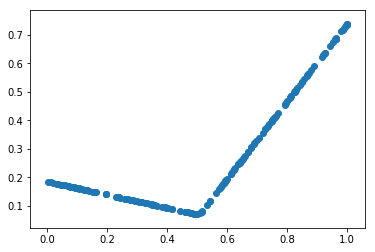

In [32]:
ffnn.eval()
y_pred = ffnn.forward(torch.from_numpy(x_test)).detach().numpy()

plt.scatter(x_test, y_pred, label='Fitted line');

# Convolutional Neural Network

In [ ]:
from torchvision.datasets import MNIST

In [ ]:
train_generator = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './mnist/', train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size=64,
    shuffle=True
)

In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root='./mnist/', train=False, download=True,
    transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
)



test_generator = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64, 
                                          shuffle=False)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, x_channel, b1_channel, b2_channel, b3_dim, y_dim,
                 kernel_size_conv, kernel_size_mp, stride_conv, stride_mp,
                 padding_conv, prob_dropout):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(x_channel, b1_channel, kernel_size=kernel_size_conv,
                      stride=stride_conv, padding=padding_conv),
            nn.BatchNorm2d(b1_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_mp, stride=stride_mp))
        self.layer2 = nn.Sequential(
            nn.Conv2d(b1_channel, b2_channel, kernel_size=kernel_size_conv,
                      stride=stride_conv, padding=padding_conv),
            nn.BatchNorm2d(b2_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_mp, stride=stride_mp))
        self.dropout = nn.Dropout(p=prob_dropout)
        self.fc = nn.Linear(7*7*b2_channel, y_dim)
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.flatten(start_dim=1)
        return self.fc(x)
    
    
    def train_(self, generator, epochs, lr=0.01, step=2, device="cpu"):
        assert(step > 1)
        self = self.to(device)
        self.optim = torch.optim.Adam(self.parameters(), lr=lr)
        liveloss = PlotLosses()

        for epoch in range(epochs):
            if epoch % step == 0:
                logs = {}
                for phase in ["train", "eval"]:
                    running_acc = 0
                    running_loss = 0.0
                    #step > 1
                    self.train() if phase == 'train' else self.eval()
                    
                    for x_data, y_data in generator[phase]:
                        x_data, y_data = x_data.to(device), y_data.to(device)
                        y_pred = self.forward(x_data)
                        loss = self.loss(y_pred, y_data)

                        if phase == "train":
                            self.optim.zero_grad()
                            loss.backward()
                            self.optim.step()
                            
                        _, labels_pred = torch.max(y_pred.data, 1)
                        running_acc += (labels_pred == y_data).sum().item()
                        running_loss += loss.item() * x_data.shape[0]

                    size = len(generator[phase].dataset)
                    logs[phase + "acc"] = running_acc / size
                    logs[phase + "loss"] = running_loss / size
                    
                liveloss.update(logs)
                liveloss.draw()

            else:
                self.train()
                for x_data, y_data in generator["train"]:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    loss = self.loss(y_pred, y_data)

                    self.optim.zero_grad()
                    loss.backward()
                    self.optim.step()


    def test(self, test_generator):
        self.eval()
        running_acc = 0
        running_loss = 0
        with torch.no_grad():
            for x_data, y_data in test_generator:
                x_data, y_data = x_data.to(device), y_data.to(device)
                y_pred = self.forward(x_data)
                running_loss += self.loss(y_pred, y_data).item()
                _, labels_pred = torch.max(y_pred.data, 1)
                running_acc += (labels_pred == y_data).sum().item() * x_data.shape[0]
                
        size = len(test_generator.dataset)
        print('Test Accuracy of the model on the {} test images: {} %'.format(size, 100 * running_acc / size))
        print('Test Cross Entropy of the model on the {} test images: {}'.format(size, running_loss / size))



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

params_model = {
    "x_channel": 1,
    "b1_channel": 16,
    "b2_channel": 32,
    "b3_dim": 128,
    "y_dim": 10,
    
    "kernel_size_conv": 5,
    "kernel_size_mp": 2,
    
    "stride_conv": 1,
    "stride_mp": 2,
    
    "padding_conv": 2,
    "prob_dropout": 0.2
}

params_train = {
    "generator": {
        "train": training_generator,
        "eval": validation_generator
    },
    "epochs": 100,
    "lr": 0.01,
    "step": 2,
    "device": device
}

    
cnn = ConvNet(**params_model)

cnn.train_(**params_train)

### Evaluation

In [ ]:
cnn.test(test_generator)

In [ ]:
test(cnn, test_generator)